In [2]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home2/clinux01/.pyenv/shims/python (found version "3.6.5") 
-- Found PythonLibs: /home2/clinux01/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- pybind11 v2.4.dev4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home2/clinux01/Desktop/tp3-metnum
-- Configuring done

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import cml


/home2/clinux01/Desktop/tp3-metnum/notebooks
Python 3.6.5


In [4]:
import numpy as np                   # Para cosas de álgebra lineal
import matplotlib.pyplot as plt      # Para gráficos
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import math
import random


In [5]:
def calcular_preds_y_errores(desde_train, hasta_train, hasta_test,grado_pol,cant_senos, archivo, columna_x, columna_y):
    
    #Obtenemos datos

    
    xi=np.arange(desde_train,hasta_train)#np.array(archivo[columna_x][desde_train:hasta_train])
    print(xi)
    yi=np.array(archivo[columna_y][desde_train:hasta_train])
    print(yi)
    xs=np.arange(hasta_train, hasta_test)#np.array(archivo[columna_x][hasta_train:hasta_test])
    print(xs)
    ys=np.array(archivo[columna_y][hasta_train:hasta_test])
    print(ys)
    
    #Calculo y eliminado de outliers
    
    #not_outliers = np.abs(yi - yi.mean()) < 2 * yi.std()
    
    
    xi_limpios=xi #[not_outliers]
    yi_limpios=yi #[not_outliers]
    

    #Armado de matriz A
    
    m = np.shape(xi_limpios)[0]

    
    cerosYequis = np.stack([np.ones(m),xi_limpios] , axis=1)
    
    cerosYequies = np.stack([xi_limpios**j for j in range(grado_pol+1)], axis=1)
    
    #print('xiLimpios:', xi_limpios,'porPi:', 2*np.pi*xi_limpios, 'Finalmente:', np.sin(2*np.pi*xi_limpios))
    
    senos = np.stack([np.sin((2*np.pi*xi_limpios)/(k)) for k in range(2,cant_senos)], axis=1)
    
    matriz = np.concatenate((cerosYequis, senos), axis =1)
    
    
    
    #mtm=matriz.T@matriz
    #mtb=matriz.T@yi_limpios
    
    
    
    #print(coefs)
    
    #Inicialización, fitting y predict

    regLineal=cml.RegresorPolinomial(grado_pol)
    regCosSen=cml.RegresorLinearYPeriodico()
    regSenoide=cml.RegresorSenoide()

    #print('Post inicializacion')
    
    regLineal.fit(cerosYequies, yi_limpios)
    regCosSen.fit(xi_limpios, yi_limpios)
    
    #print('Pre fit senoide')
    
    regSenoide.fit(matriz, yi_limpios)

    #print('Post fit')
    
    pred_poli = regLineal.predict(xs)
    pred_Cos_Sen = regCosSen.predict(xs)
    pred_Senoide = regSenoide.predict(xs)
    
    
    #print(pred_poli)
    #print(pred_Cos_Sen)
    #print(pred_Senoide)
    #print('Post predict')
    
    #coefsPy=np.linalg.solve(mtm, mtb)
    #coefsC=regSenoide.mostrarCoefs()
    
    #$print('En python:', coefsPy)
    #print('En c++:', coefsC)
    
    #Calculo errores
    maxtrain = np.amax(yi)
    mintrain = np.amin(yi)
    maxtest = np.amax(ys)
    mintest= np.amin(ys)
    maximo = max(maxtrain, maxtest)
    minimo = min(mintrain, mintest)
    dif = maximo - minimo
    
    #print(dif)
    
    
    
    poli_error = cml.ecm(pred_poli, ys)/dif
    cos_sen_error = cml.ecm(pred_Cos_Sen, ys)/dif
    senoide_error = cml.ecm(pred_Senoide, ys)/dif
    

    #Devolvemos las predicciones
    
    
    return pred_poli, poli_error, pred_Cos_Sen, cos_sen_error, pred_Senoide, senoide_error

def similaridadMes(archivo):
    
    #En un rango de años, vamos a agarrar un mes y calcular su varianza entre los años
    
    #hacemos un arreglo de 13 elementos, uno por cada mes y uno de control
    #El control toma meses al azar de cada uno de los años

    
    otps_meses = []
    
    for i in range(13):
        otps_meses.append([])
    
    var_meses = np.zeros(13)
    
    for anio in range(11):
        anio_init = 11*anio
        
        for mes in range(12):
            otp_del_mes = archivo.iloc[anio_init + mes][2]
            otps_meses[mes].append(otp_del_mes)
        
        # mete en el control el valor para un mes random de ese año
        
        #mes = random.randrange(0, 12, 1)
        #otp_del_mes = archivo.iloc[anio_init + mes][2]
        #otps_meses[12].append(otp_del_mes) 
    
    for i in range(12):
        var_meses[i] = np.std(otps_meses[i])/np.mean(otps_meses[i])
        
    todos_los_otps_meses = archivo[' otp']
    var_meses[12] = np.std(todos_los_otps_meses)/np.mean(todos_los_otps_meses)
    
    #indicador de desvío estándar, dividido por el promedio de valores por el promedio
        
    return var_meses
        
        #if anioActual != df.iloc[i][0].astype(int):
        #print(cantVuelos)
        #print(cantDelays)
        #otps.append([anioActual, (cantDelays/cantVuelos)*100])
        #anioActual+=1
        #cantVuelos=0
        #cantDelays=0
        #mesActual=1
    #mesActual+=1
   # cantVuelos+=df.iloc[i][1]
    #cantDelays+=df.iloc[i][2] + df.iloc[i][4]
    

In [6]:
def calcular_preds_y_errores2(desde_train, hasta_train, hasta_test,grado_pol,cant_senos, archivo, columna_x, columna_y):
    
    #Obtenemos datos

    
    #xi=np.arange(desde_train,hasta_train)#np.array(archivo[columna_x][desde_train:hasta_train])
    xi=np.array([desde_train, desde_train + 12, desde_train + 24])
    print(xi)
    yiinit=np.array(archivo[columna_y])
    yi=np.array([yiinit[xi[0]],yiinit[xi[1]],yiinit[xi[2]]])
    print(yi)
    #xs=np.arange(hasta_train, hasta_test)#np.array(archivo[columna_x][hasta_train:hasta_test])
    xs=np.array([xi[2]+12])
    print(xs)
    ysinit=np.array(archivo[columna_y])
    ys=np.array([ysinit[xs[0]]])
    print(ys)
    
    #Calculo y eliminado de outliers
    
    #not_outliers = np.abs(yi - yi.mean()) < 2 * yi.std()
    
    
    xi_limpios=xi #[not_outliers]
    yi_limpios=yi #[not_outliers]
    

    #Armado de matriz A
    
    m = np.shape(xi_limpios)[0]

    
    cerosYequis = np.stack([np.ones(m),xi_limpios] , axis=1)
    
    cerosYequies = np.stack([xi_limpios**j for j in range(grado_pol+1)], axis=1)
    
    #print('xiLimpios:', xi_limpios,'porPi:', 2*np.pi*xi_limpios, 'Finalmente:', np.sin(2*np.pi*xi_limpios))
    
   
    
    
    
    #mtm=matriz.T@matriz
    #mtb=matriz.T@yi_limpios
    
    
    
    #print(coefs)
    
    #Inicialización, fitting y predict

    regLineal=cml.RegresorPolinomial(grado_pol)


    #print('Post inicializacion')
    
    regLineal.fit(cerosYequies, yi_limpios)
    

    #print('Post fit')
    
    pred_poli = regLineal.predict(xs)
 
    
    #print(pred_poli)
    #print(pred_Cos_Sen)
    #print(pred_Senoide)
    #print('Post predict')
    
    #coefsPy=np.linalg.solve(mtm, mtb)
    #coefsC=regSenoide.mostrarCoefs()
    
    #$print('En python:', coefsPy)
    #print('En c++:', coefsC)
    
    #Calculo errores
    maxtrain = np.amax(yi)
    mintrain = np.amin(yi)
    maxtest = np.amax(ys)
    mintest= np.amin(ys)
    maximo = max(maxtrain, maxtest)
    minimo = min(mintrain, mintest)
    dif = maximo - minimo
    
    #print(dif)
    
    
    
    poli_error = cml.ecm(pred_poli, ys)/dif
  

    #Devolvemos las predicciones
    
    
    return pred_poli, poli_error

In [ ]:
#CML mensual

otps_archivo=pd.read_csv("../results/otps_mensuales_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = [0, 20, 40, 60]
rangos_train = [3, 5, 10, 20]
rangos_test  = [1, 5, 10]

anios=np.array(otps_archivo['Anio'])

meses=np.array(otps_archivo[' Mes'])

resultados = []

for i in range(len(desdes_train)):
    n1 = desdes_train[i]
    for j in range(len(rangos_train)):
        n2 = n1 + rangos_train[j]
        for k in range(len(rangos_test)):
            n3 = n2 + rangos_test[k]
            resultados.append([desdes_train[i], rangos_train[j], rangos_test[k], calcular_preds_y_errores(n1, n2, n3, 3, 5, otps_archivo, ' Mes', ' otp')])

f = open('../results/granularidadMesesErrorPorRegresor.txt', 'w')

f.write('{},{},{},{},{},{},{}\n'.format('AnioInicial','MesInicial','rangoEntrenamiento','rangoTest','errPol','errSenCos','errSenoides'))

for res in resultados:
    f.write('{},{},{},{},{},{},{}\n'.format(anios[res[0]], meses[res[0]], res[1], res[2],res[3][1],res[3][3],res[3][5]))
    print(meses[res[1]])

f.close()

In [ ]:
#Varianza otp por meses

#otps_archivo=pd.read_csv("../results/otps_anuales_1998_2008.csv", index_col=False,header=0)

var_archivo=pd.read_csv("../results/otps_mensuales_1998_2008.csv", index_col=False,header=0)

print("Cantidad de documentos: {}".format(var_archivo.shape[0]))

#info1998-2008.csv

#print(similaridadMes(otps_archivo))


f = open('../results/varianzaPorMeses.txt', 'w')

resultVarianzas = similaridadMes(var_archivo)

f.write('{},{}\n'.format('Mes','Vc'))

for i in range(13):
    f.write('{},{}\n'.format(i,resultVarianzas[i]))

f.close()


#a=calcular_preds_y_errores(0, 3, 6,8,8, otps_archivo, 'Anio', ' otp')
#variable = [1, 2, 3]
#variable.append(a)
#print(variable)

In [ ]:
#CML anual

otps_archivo=pd.read_csv("../results/otps_anuales_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = [0, 2]
rangos_train = [3, 5]
rangos_test  = [1, 4]

anios=np.array(otps_archivo['Anio'])


resultados = []

for i in range(len(desdes_train)):
    n1 = desdes_train[i]
    for j in range(len(rangos_train)):
        n2 = n1 + rangos_train[j]
        for k in range(len(rangos_test)):
            n3 = n2 + rangos_test[k]
            resultados.append([desdes_train[i], rangos_train[j], rangos_test[k], calcular_preds_y_errores(n1, n2, n3, 3, 9, otps_archivo, 'Anio', ' otp')])

f = open('../results/granularidadAniosErrorPorRegresorK=k+3.txt', 'w')

f.write('{},{},{},{},{},{}\n'.format('AnioInicial','rangoEntrenamiento','rangoTest','errPol','errSenCos','errSenoides'))

for res in resultados:
    f.write('{},{},{},{},{},{}\n'.format(anios[res[0]], res[1], res[2],res[3][1],res[3][3],res[3][5]))
    

f.close()

In [ ]:
df = pd.read_csv("../data/1998.csv",delimiter=",", index_col=False)

print(df)

print("Cantidad de documentos: {}".format(df.shape[0]))


otps = []

#f = open('../results/pruebas.txt', 'w')

cantVuelos = 0
#cantDelays = 0
anioActual = 1998
mesActual = 1

#for i in range(132):
 #   if anioActual != df.iloc[i][0].astype(int):
        #print(cantVuelos)
        #print(cantDelays)
        #otps.append([anioActual, (cantDelays/cantVuelos)*100])
        #anioActual+=1
        #cantVuelos=0
        #cantDelays=0
        #mesActual=1
    #mesActual+=1
   # cantVuelos+=df.iloc[i][1]*2
    #cantDelays+=df.iloc[i][2] + df.iloc[i][4]
    
#otps.append([anioActual, (cantDelays/cantVuelos)*100])
#f.write('{}-{}, {}\n'.format('anio','mes', 'otp'))
    
#for otp in otps:
 #   print(otp)
  #  f.write('{}, {}\n'.format(otp[0], otp[1]))
    #f.write('{}, {}, {}\n'.format(otp[0], otp[1], otp[2]))

#f.close()

In [ ]:
dias = pd.read_csv('../results/dia/info_dia1998-2008_REMOTE_6226.csv', sep=',')

dias['fecha']=pd.to_datetime(dias['fecha'])
dias.sort_values(by=['fecha'],inplace=True)



f = open('../results/otps_diarios_1998_2008_aux.csv', 'w')

f.write('{},{},{},{}\n'.format('Anio','Mes','Dia','otp'))

for fecha in range(4018):
    anio=dias.iloc[fecha][0].year
    mes=dias.iloc[fecha][0].month
    dia=dias.iloc[fecha][0].day
    otp=(dias.iloc[fecha][2]+dias.iloc[fecha][3])*100/(dias.iloc[fecha][1]*2)
    print(dias.iloc[fecha][2])
    f.write('{},{},{},{}\n'.format(anio,mes,dia,otp))
f.close()
dias.shape[0]

In [ ]:
#CML diario

otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = [0, 150, 300, 450, 600, 1200, 3000]
rangos_train = [7, 10, 20, 40]
rangos_test  = [1, 5, 10]

anios=np.array(otps_archivo['Anio'])
meses=np.array(otps_archivo['Mes'])
dias=np.array(otps_archivo['Dia'])

resultados = []

for i in range(len(desdes_train)):
    n1 = desdes_train[i]
    for j in range(len(rangos_train)):
        n2 = n1 + rangos_train[j]
        for k in range(len(rangos_test)):
            n3 = n2 + rangos_test[k]
            resultados.append([desdes_train[i], rangos_train[j], rangos_test[k], calcular_preds_y_errores(n1, n2, n3, 3, 5, otps_archivo, 'Anio', 'otp')])

f = open('../results/granularidadDiasErrorPorRegresor.txt', 'w')

f.write('{},{},{},{},{},{},{},{}\n'.format('AnioInicial','MesInicial','DiaInicial','rangoEntrenamiento','rangoTest','errPol','errSenCos','errSenoides'))

for res in resultados:
    f.write('{},{},{},{},{},{},{},{}\n'.format(anios[res[0]],meses[res[0]],dias[res[0]], res[1], res[2],res[3][1],res[3][3],res[3][5]))
    

f.close()

In [ ]:
f = pd.read_csv('../results/otps_diarios_1998_2008.csv',header=0)

#f['otp'] /=2

f.to_csv('../results/otps_diarios_1998_2008.csv',index=False, sep=',')

In [ ]:
print(f)


In [ ]:
def similaridadDia(archivo):
    
    #En un rango de años, vamos a agarrar un dia y calcular su vc

    
    otps_dias = []
    
    for i in range(15):
        otps_dias.append([])
    
    var_dias = np.zeros(15)
    
    indicesDias = [[12,31],[1,1],[1,5],[12,24],[12, 25],[5,25],[5,30],[6,5],[7,3],[7,4],[7,15],[8,1],[8,17],[9,5],['Control', '-']]
    print(len(indicesDias))
    print(archivo.shape[0])
        # mete en el control el valor para un mes random de ese año
        
        #mes = random.randrange(0, 12, 1)
        #otp_del_mes = archivo.iloc[anio_init + mes][2]
        #otps_meses[12].append(otp_del_mes) 
    
    for i in range(archivo.shape[0]):
        for j in range(14):
            if archivo.iloc[i][1] == indicesDias[j][0] and archivo.iloc[i][2] == indicesDias[j][1]:
                otps_dias[j].append(archivo.iloc[i][3])
                otps_dias[14].append(archivo.iloc[i][3])
                break
    
    for i in range(15):
        var_dias[i] = np.std(otps_dias[i])/np.mean(otps_dias[i])
        
    return indicesDias, var_dias
    #como control, ahora sumar todos estos que ya tenemos
    #indicador de desvío estándar, dividido por el promedio de valores por el promedio
        


In [ ]:
#Varianza otp por dias
#otps_archivo=pd.read_csv("../results/otps_anuales_1998_2008.csv", index_col=False,header=0)

var_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

print("Cantidad de documentos: {}".format(var_archivo.shape[0]))

#info1998-2008.csv

#print(similaridadMes(otps_archivo))


f = open('../results/varianzaPorDias.txt', 'w')

indicesVarianzas, varianzasdias = similaridadDia(var_archivo)

f.write('{},{},{}\n'.format('Mes','Dia','Vc'))

for i in range(15):
    f.write('{},{},{}\n'.format(indicesVarianzas[i][0], indicesVarianzas[i][1], varianzasdias[i]))

f.close()


#a=calcular_preds_y_errores(0, 3, 6,8,8, otps_archivo, 'Anio', ' otp')
#variable = [1, 2, 3]
#variable.append(a)
#print(variable)

In [ ]:
#CML ultimos 3 meses

otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = [0, 150, 300, 450, 600, 1200, 3000]
rangos_train = [90]
rangos_test  = [30]

anios=np.array(otps_archivo['Anio'])
meses=np.array(otps_archivo['Mes'])
dias=np.array(otps_archivo['Dia'])

resultados = []

f = open('../results/ultimosTresMesesParaPredecirProximo4.txt', 'w')

for i in range(len(desdes_train)):
    n1 = desdes_train[i]
    for j in range(len(rangos_train)):
        n2 = n1 + rangos_train[j]
        for k in range(len(rangos_test)):
            n3 = n2 + rangos_test[k]
            print('por llamar función')
            soluciones=calcular_preds_y_errores(n1, n2, n3, 8, 6, otps_archivo, 'Anio', 'otp')
            print(soluciones)
            resultados.append([desdes_train[i], rangos_train[j], rangos_test[k], soluciones])



f.write('{},{},{},{},{},{}\n'.format('AnioInicial','MesInicial','DiaInicial','errPol','errSenCos','errSenoides'))

for res in resultados:
    f.write('{},{},{},{},{},{}\n'.format(anios[res[0]],meses[res[0]],dias[res[0]],res[3][1],res[3][3],res[3][5]))
    

f.close()


In [ ]:
#Experimentos 9/11

otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

#Experimentos años

print(otps_archivo['Dia'].shape)

desdes_train = [0]
rangos_train = [90]
rangos_test  = [30]

anios=np.array(otps_archivo['Anio'])
meses=np.array(otps_archivo['Mes'])
dias=np.array(otps_archivo['Dia'])

resultados = []

f = open('../results/911.txt', 'w')

for i in range(len(desdes_train)):
    n1 = desdes_train[i]
    for j in range(len(rangos_train)):
        n2 = n1 + rangos_train[j]
        for k in range(len(rangos_test)):
            n3 = n2 + rangos_test[k]
            resultados.append([desdes_train[i], rangos_train[j], rangos_test[k], calcular_preds_y_errores(n1, n2, n3, 8, 4, otps_archivo, 'Anio', 'otp')])



#f.write('{},{},{},{},{},{}\n'.format('AnioInicial','MesInicial','DiaInicial','errPol','errSenCos','errSenoides'))

#for res in resultados:
#    f.write('{},{},{},{},{},{}\n'.format(anios[res[0]],meses[res[0]],dias[res[0]],res[3][1],res[3][3],res[3][5]))
    

#f.close()

In [ ]:
#Prediccion Lineal, ultimos 3 meses
otps_archivo=pd.read_csv("../results/otps_mensuales_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = [105,106,107,108,109,110,111,112,113,114,115,116]



meses=np.array(otps_archivo[' Mes'])
print(meses)

resultados = []

for i in range(len(desdes_train)):
    resultados.append([desdes_train[i], calcular_preds_y_errores(desdes_train[i], desdes_train[i]+3, desdes_train[i]+4, 1, 5, otps_archivo, ' Mes', ' otp')])
    print(resultados)

f = open('../results/aproximacionLinealUltimos3Meses2004(es2007).txt', 'w')

f.write('{},{}\n'.format('Mes','errLineal'))

for res in resultados:
    f.write('{},{}\n'.format(meses[res[0]], res[1][1]))
    

f.close()

In [ ]:
#CML torres gemelas

otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

#Experimentos años

desdes_train = []
for i in range(otps_archivo.shape[0]):
    if otps_archivo.iloc[i][1] ==  9 and otps_archivo.iloc[i][2] == 11:
        if otps_archivo.iloc[i][0] >= 1999 and otps_archivo.iloc[i][0] <= 2003:
            desdes_train.append(i)
    
print(desdes_train)

anios=np.array(otps_archivo['Anio'])
meses=np.array(otps_archivo['Mes'])
dias=np.array(otps_archivo['Dia'])

resultados = []

f = open('../results/torresGemelas30diasa10.txt', 'w')

for i in range(len(desdes_train)):
    n2 = desdes_train[i]
    n1 = n2 - 30
    n3 = n2 + 10
    print('por llamar función')
    soluciones=calcular_preds_y_errores(n1, n2, n3, 1, 3, otps_archivo, 'Anio', 'otp')
    print(soluciones)
    resultados.append([desdes_train[i], soluciones])
    
    plt.plot()




f.write('{},{},{},{}\n'.format('Anio','errPol','errSenCos','errSenoides'))

for res in resultados:
    f.write('{},{},{},{}\n'.format(anios[res[0]],res[1][1],res[1][3],res[1][5]))
    

f.close()

[-2.42203429e+01  6.46985705e-02  1.58020981e+12]
[-2.42203429e+01  6.46985705e-02  1.58020981e+12]
[-2.42203429e+01  6.46985705e-02  1.58020981e+12]
[-3.27829605e+01  7.62734773e-02  1.19736078e+12 -9.03837786e+12
  5.52413329e-01  8.90679004e-01  1.00297530e+00]
[-3.27829605e+01  7.62734773e-02  1.19736078e+12 -9.03837786e+12
  5.52413329e-01  8.90679004e-01  1.00297530e+00]
[-3.27829605e+01  7.62734773e-02  1.19736078e+12 -9.03837786e+12
  5.52413329e-01  8.90679004e-01  1.00297530e+00]
[-3.74116585e+01  8.16513778e-02 -3.24683382e+11 -4.32523292e+12
  4.59971742e-01  1.02665452e+00  8.99337277e-01 -2.17057850e+00
 -2.09235223e+00  5.49613193e-02 -1.78369591e-01 -1.07078172e+00
  1.34450621e+00  3.51504550e-01 -8.80302029e+00  5.61647672e+00
 -1.25345267e+01  1.70539235e+01  5.94356401e+00 -3.50300816e+00]
[-3.74116585e+01  8.16513778e-02 -3.24683382e+11 -4.32523292e+12
  4.59971742e-01  1.02665452e+00  8.99337277e-01 -2.17057850e+00
 -2.09235223e+00  5.49613193e-02 -1.78369591e-01 

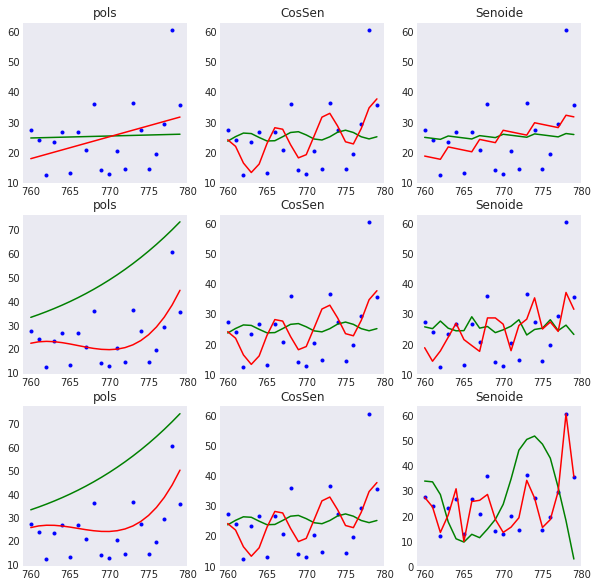

In [8]:
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (10, 10)


otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

grados = [[1, 3], [7,7], [20,20]]

#f = open('../results/distintosFitsDiaArbitrario700,60,20', 'w')

#f.write('{},{},{},{},{},{},{},{},{},{},{},{}\n'.format('GradoPolinomio','CantidadSenoides','valoresXtrain','valoresXtest','valoresYtrain','valoresYtest','coeficientesPolinomioTr','coeficientesPolinomioTs','coeficientesCosTr','coeficientesCosTs','coeficientesSenoidTr','coeficientesSenoidTs'))

fig, axs = plt.subplots(3, 3)


for i in range(3):
    for j in range(3):
        misXtrain, misXtest, misYtrain, misYtest, pred_poliTr, pred_poliTs, pred_CosTr, pred_CosTs, pred_SenoideTr, pred_SenoideTs = paraGraficarCml(700,760,780,grados[i][0],grados[i][1],otps_archivo,'Anio','otp')
    
    #f.write('{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
    #grado[0],grado[1],misXtrain, misXtest, misYtrain, misYtest, cPol, cpoltest, cCos, cCostest, cSenoid, csenoidtest))
        funcTr=None
        funcTs=None
        if j == 0:
            funcTr = pred_poliTr
            funcTs = pred_poliTs
            axs[i, j].set_title('pols')
            ax.set(xlabel='x-label', ylabel='y-label')
        elif j == 1:
            funcTr = pred_CosTr
            funcTs = pred_CosTs
            axs[i, j].set_title('CosSen')
        elif j == 2:
            funcTr = pred_SenoideTr
            funcTs = pred_SenoideTs
            axs[i, j].set_title('Senoide')
            
    
        axs[i, j].plot(misXtest, misYtest, 'b.')
        axs[i, j].plot(misXtest, funcTr, 'g-')
        axs[i, j].plot(misXtest, funcTs, 'r-')
        
        
        #plt.subplot(3, 3, i*3 + j+1)
        #plt.ylabel('ys')
        #plt.xlabel('xs')
        #plt.plot(misXtest, misYtest, 'b.')
        #plt.plot(misXtest, funcTr, 'g-')
        #plt.plot(misXtest, funcTs, 'r-')
 

In [7]:
def paraGraficarCml(desde_train, hasta_train, hasta_test,grado_pol,cant_senos, archivo, columna_x, columna_y):
    
    #Obtenemos datos

    
    xi=np.arange(desde_train,hasta_train)#np.array(archivo[columna_x][desde_train:hasta_train])
    #print(xi)
    yi=np.array(archivo[columna_y][desde_train:hasta_train])
    #print(yi)
    xs=np.arange(hasta_train, hasta_test)#np.array(archivo[columna_x][hasta_train:hasta_test])
    #print(xs)
    ys=np.array(archivo[columna_y][hasta_train:hasta_test])
    #print(ys)
    
    #Calculo y eliminado de outliers
    
    #not_outliers = np.abs(yi - yi.mean()) < 2 * yi.std()
    
    
    xi_limpios=xi #[not_outliers]
    yi_limpios=yi #[not_outliers]
    
    
    #Armado de matriz A
    n = np.shape(xi_limpios)[0]
    m = np.shape(xs)[0]

    
    cerosYequis = np.stack([np.ones(n),xi_limpios] , axis=1)
    
    cerosYequies = np.stack([xi_limpios**j for j in range(grado_pol+1)], axis=1)
    cerosYequisTest = np.stack([np.ones(m),xs] , axis=1)
    cerosYequiesTest = np.stack([xs**j for j in range(grado_pol+1)], axis=1)
    
    senos = np.stack([np.sin((2*np.pi*xi_limpios)/(k-1)) for k in range(2,cant_senos)], axis=1)
    senosTest = np.stack([np.sin((2*np.pi*xs)/(k-1)) for k in range(2,cant_senos)], axis=1)
    
    matriz = np.concatenate((cerosYequis, senos), axis =1)
    
    
    matrizTest = np.concatenate((cerosYequisTest, senosTest), axis =1)
    
    
    
    #mtm=matriz.T@matriz
    #mtb=matriz.T@yi_limpios
    
    
    
    #print(coefs)
    
    #Inicialización, fitting y predict

    regLineal=cml.RegresorPolinomial(grado_pol)
    regCosSen=cml.RegresorLinearYPeriodico()
    regSenoide=cml.RegresorSenoide()
    
    regLinealTest=cml.RegresorPolinomial(grado_pol)
    regCosSenTest=cml.RegresorLinearYPeriodico()
    regSenoideTest=cml.RegresorSenoide()

    #print('Post inicializacion')
    
    regLineal.fit(cerosYequies, yi_limpios)
    regCosSen.fit(xi_limpios, yi_limpios)
    regSenoide.fit(matriz, yi_limpios)
    
    regLinealTest.fit(cerosYequiesTest, ys)
    regCosSenTest.fit(xs, ys)
    regSenoideTest.fit(matrizTest,ys)

    
    #print('Pre fit senoide')
    
    

    print(regSenoide.mostrarCoefs())
    #print('Post fit')
    
    pred_poliTr = regLineal.predict(xs)
    pred_Cos_SenTr = regCosSen.predict(xs)
    pred_SenoideTr = regSenoide.predict(xs)
    
    pred_poliTs = regLinealTest.predict(xs)
    pred_Cos_SenTs = regCosSenTest.predict(xs)
    pred_SenoideTs = regSenoideTest.predict(xs)
    
    
   
    
    #print(pred_poli)
    #print(pred_Cos_Sen)
    #print(pred_Senoide)
    

    #Devolvemos las predicciones
    
    
    return xi, xs, yi, ys, pred_poliTr, pred_poliTs, pred_Cos_SenTr, pred_Cos_SenTs, pred_SenoideTr, pred_SenoideTs

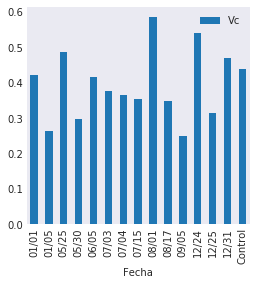

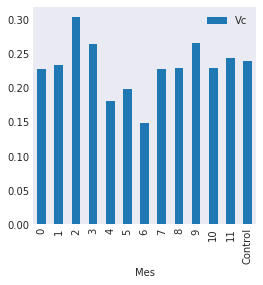

In [11]:
#otps_archivo=pd.read_csv("../results/otps_diarios_1998_2008.csv", index_col=False,header=0)

archivo =pd.read_csv('../results/varianzas/varianzaPorDias.txt', index_col=False, header=0)
#meses=np.array(archivo['Mes'][:15])
#varianza=np.array(archivo['Vc'])

#print(varianza)

#plt.plot(meses, varianza, 'r-')

meses=pd.read_csv('../results/varianzas/varianzaPorMeses.txt', index_col=False, header=0)

archivo.plot(kind='bar', x='Fecha',figsize=(4,4))

meses.plot(kind='bar',x='Mes',figsize=(4, 4))

